,OP1,OP2,OP3,OP4,OP5
0,9,42,28,37,11
1,19,37,21,34,13
2,10,21,14,48,18
3,8,24,19,40,14
4,11,26,20,31,9


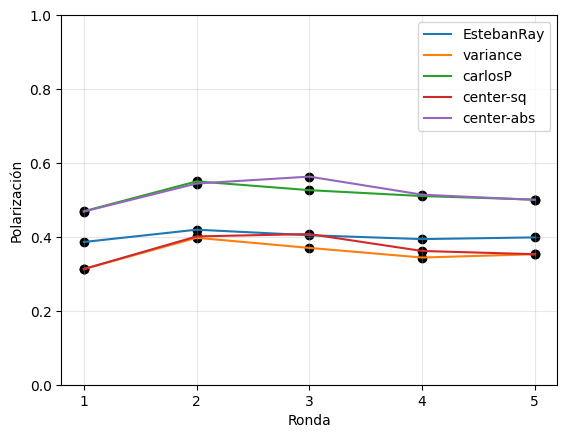

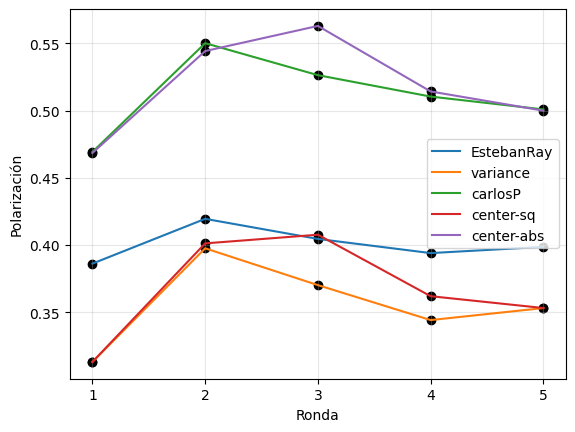

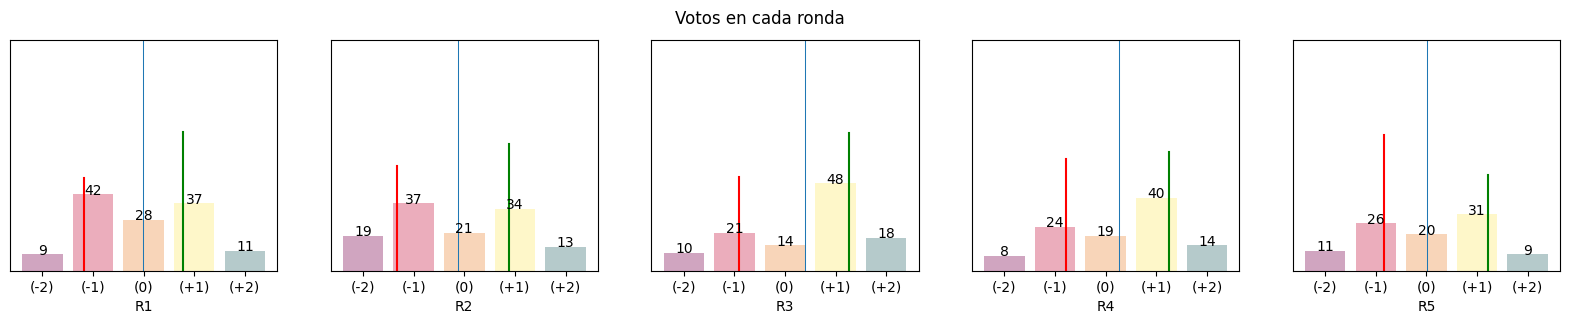

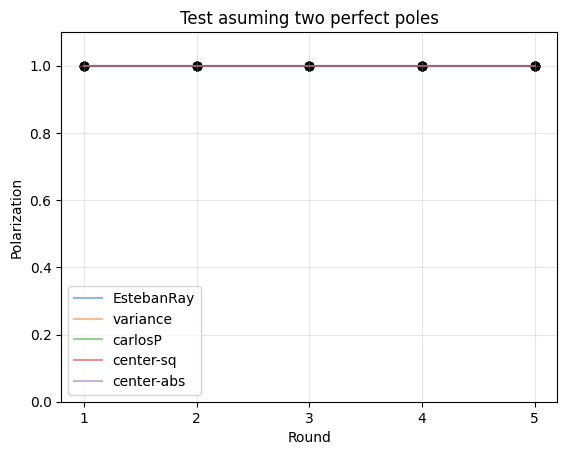

In [7]:
import pandas as pd
from math import pow
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath

########################################
# Some Constants
########################################
LTITLES = [
    "(-2) Totalmente en desacuerdo",
    "(-1) Moderadamente en desacuerdo",
    "( 0) Ni de acuerdo, ni en desacuerdo",
    "(+1) Moderadamente de Acuerdo",
    "(+2) Totalmente de Acuerdo",
]

LTITLES_SHORT = ["(-2)", "(-1)", "(0)", "(+1)", "(+2)"]
NUMBINS = len(LTITLES)
NUMCOLS = len(LTITLES_SHORT)

COLORS = [
    "#d0a5c0",
    "#ebadbc",
    "#f8d5b9",
    "#fef7c9",
    "#b5cacb",
    "#b5cacb",
    "#f5a87d",
] * 10
FIGSIZE = (20, 3)


########################################
# Polarization measures
########################################
def polarization(bins, K=1.0, alpha=1.6, distance=0.2):
    """Esteban-Ray polarization meassure

    Parameters
    ----------
      bins : int list
        Population in each bin
      K : float
        Normalization constant
      alpha : float
        Identification constant
      distance : float
        Disntance between the bin i and i+1
    """
    sum = 0.0
    for i, pi in enumerate(bins):
        for j, pj in enumerate(bins):
            sum += pow(pi, alpha) * pj * distance * abs(i - j)

    return K * sum


def maxPolarization(bins, K=1, alpha=1.6, distance=0.2):
    """
    Maximal value for polarization when 1/2 of the population
    is in each extreme
    """

    population = sum(bins)
    n = len(bins)
    binextreme = [0.0] * n
    binextreme[0] = population / 2
    binextreme[n - 1] = population / 2

    return polarization(binextreme, K, alpha, distance)


# In the following metrics, x is an array with votes in [0, 1]
def metric_ER(x):
    _, count = np.unique(np.sort(x), return_counts=True)
    ans = polarization(bins=count, K=1, alpha=1.6, distance=0.2)
    ansMax = maxPolarization(bins=count, K=1, alpha=1.6, distance=0.2)
    return ans / ansMax


def metric_carlosP(x):
    x = np.asarray(x)
    assert 0 <= x.min() <= x.max() <= 1, f"Out of range: {x.min()}, {x.max()}"
    L = x < x.mean()
    R = ~L
    return 0 if R.all() else 4 * L.mean() * R.mean() * (x[R].mean() - x[L].mean())


def metric_var(x):
    x = np.asarray(x)
    assert 0 <= x.min() <= x.max() <= 1, f"Out of range: {x.min()}, {x.max()}"
    return 4 * np.var(x)


def metric_squared(x):
    x = np.asarray(x)
    assert 0 <= x.min() <= x.max() <= 1, f"Out of range: {x.min()}, {x.max()}"
    return 4 * np.mean((x - 0.5) ** 2)


def metric_abs(x):
    x = np.asarray(x)
    assert 0 <= x.min() <= x.max() <= 1, f"Out of range: {x.min()}, {x.max()}"
    return 2 * np.mean(np.abs(x - 0.5))


df_counts = pd.read_excel("data.xlsx", sheet_name="data")
df_counts = df_counts.iloc[:, 1:]
display(df_counts)
arr_counts = df_counts.to_numpy()
del df_counts
n_rounds = len(arr_counts)

# Recreate individual votes to match the counts:
round_votes = [np.concatenate([[i] * n for i, n in enumerate(r)]) for r in arr_counts]

# Normalize the votes from [0, 1, 2, 3, 4] into [0, 1/4, 1/2, 3/4, 1]
round_votes = [votes / 4 for votes in round_votes]

# Verify correctness of the two previous operations:
for i, counts in enumerate(arr_counts):
    assert len(round_votes[i]) == counts.sum()
    _, count = np.unique(round_votes[i], return_counts=True)
    assert np.all(count == counts)

plt.style.context("fivethirtyeight")
YLIM = [0, sum(arr_counts[0, :])]

metrics = {
    "EstebanRay": metric_ER,
    "variance": metric_var,
    "carlosP": metric_carlosP,
    "center-sq": metric_squared,
    "center-abs": metric_abs,
}

for plt_num in range(2):
    ax = plt.gca()

    for name, f in metrics.items():
        x = range(1, 6)
        y = [f(x) for x in round_votes]
        ax.plot(x, y, label=name)
        ax.scatter(x, y, color="black")
    ax.legend()
    ax.grid(alpha=0.3)
    # ax.axhline(0, c='black')
    # ax.scatter(range(1, 6), [0]*5, color='black')
    if plt_num == 0:
        ax.set_ylim([0, 1])
    ax.set_xticks(range(1, 6))
    ax.set_ylabel("Polarización")
    ax.set_xlabel("Ronda")
    plt.show()


fig, axes = plt.subplots(1, len(round_votes), figsize=FIGSIZE)
fig.subplots_adjust(hspace=0.75)
for i in range(n_rounds):
    counts = arr_counts[i]
    ax = axes[i]
    ax.set_ylim(YLIM)
    ax.bar(LTITLES_SHORT, counts, color=COLORS)
    ax.set_xlabel(f"R{i+1}")

    ax.tick_params(left=False, right=False, labelleft=False)
    for idx, value in enumerate(counts):
        ax.text(idx, value, str(value), ha="center")

    x = round_votes[i] * 4
    mu = x.mean()
    L = x < mu
    R = x > mu
    xL = x[L].mean()
    xR = x[R].mean()
    ax.plot([xL, xL], [0, L.mean() * YLIM[1]], color="red")
    ax.plot([xR, xR], [0, R.mean() * YLIM[1]], color="green")
    # print(mu)
    # print(xR-xL)
    # dots = np.linspace(0, 4, 16)
    # dots_between = dots[(xL <= dots) & (dots <= xR)]
    # ax.scatter(dots_between, np.ones_like(dots_between) * YLIM[1] * 0.9, s=1)
    ax.axvline(mu, linewidth=0.75)

fig.suptitle("Votos en cada ronda")
plt.show()

# Test for the maximum
ax = plt.gca()

for name, f in metrics.items():
    x = range(1, 6)
    y = [f([0, 1]) for _ in round_votes]
    ax.plot(x, y, label=name, alpha=0.5)
    ax.scatter(x, y, color="black")
ax.set_title("Test asuming two perfect poles")
ax.legend()
ax.set_ylabel("Polarization")
ax.set_xlabel("Round")
ax.grid(alpha=0.3)
# ax.axhline(0, c='black')
# ax.scatter(range(1, 6), [0]*5, color='black')
ax.set_ylim([0, 1.1])
ax.set_xticks(range(1, 6))
plt.show()